In [222]:
import pydpmd as dp
from pydpmd.plot import draw_particles_frame, create_animation, downsample, draw_circle
from pydpmd.utils import split_systems, join_systems
import matplotlib.pyplot as plt
import numpy as np
import os
from mode_resources import *
from system_building_resources import *
import subprocess
import h5py
from collections import defaultdict
from correlation_functions import compute_stress_acf, compute_einstein_helfand_stress_acf
from scipy.interpolate import make_smoothing_spline
import pandas as pd
from matplotlib.colors import LogNorm

def get_relaxation_time(f, t):
    tau = np.interp(1 / np.e, f[::-1], t[::-1])
    if not np.min(f) < 1 / np.e:
        return np.nan
    return tau

def calc_acf(Y, t):
    shape = [len(t) - 1]
    windows = np.zeros(shape)
    shape.extend(list(Y[0].shape))
    results = np.zeros(shape)
    for i in tqdm(range(1, len(t))):
        results[i - 1] = np.sum(Y[i:] * Y[:-i], axis=0) / (t[i:].size)
        windows[i - 1] = i
    return results, windows

# Disk

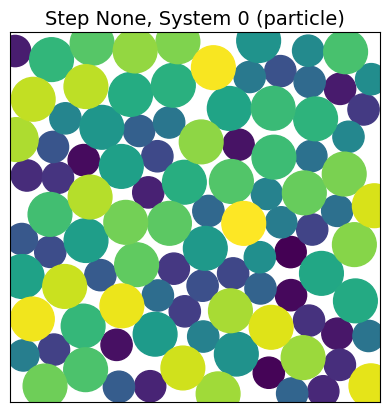

In [2]:
root = '/home/mmccraw/dev/data/11-01-25/'
data = dp.data.load(os.path.join(root, 'jamming/disk-large/jamming/'), location=["final", "init"])
draw_particles_frame(None, plt.gca(), data, 0, True, 'particle', 'viridis', 'final')

In [112]:
data_new = []
# for temperature in np.linspace(1e-5, 1e-1, 100):
for temperature in np.linspace(1e-5, 5e-5, 10):
    for delta_phi in [-1e-6, -1e-5, -1e-4, -1e-3, -1e-2, -1e-1, -2e-1, -3e-1, -4e-1, -5e-1]:
        data = dp.data.load(os.path.join(root, 'jamming/disk-large/jamming/'), location=["final", "init"])
        del data.final.arrays['hessian_xx'], data.final.arrays['hessian_xy'], data.final.arrays['hessian_yx'], data.final.arrays['hessian_yy'], data.final.arrays['pair_dist'], data.final.arrays['pair_forces'], data.final.arrays['pair_ids']
        data.add_array(np.arange(data.n_systems()), 'original_system_id')
        data.add_array(np.ones(data.n_systems()) * delta_phi, 'delta_phi')
        data.add_array(np.ones(data.n_systems()) * temperature, 'target_temp')
        data.scale_to_packing_fraction(data.packing_fraction + delta_phi)
        data.set_velocities(temperature, np.random.randint(0, 1e9))
        data_new.append(data)
data_new = join_systems(data_new)

In [113]:
dynamics_path = os.path.join(root, 'dynamics')

In [114]:
dynamics_path = os.path.join(root, 'dynamics')
data_new.set_neighbor_method(NeighborMethod.Cell)
set_standard_cell_list_parameters(data_new, 0.3)
data_new.save(dynamics_path)

n_steps = 1e5
save_freq = 1e2
dt = 1e-2

subprocess.run([
    os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_disk_pbc_final"),
    dynamics_path,
    dynamics_path,
    str(n_steps),
    str(save_freq),
    str(dt),
], check=True)

Running for 100000 steps
Step 0
Step 10000
Step 20000
Step 30000
Step 40000
Step 50000
Step 60000
Step 70000
Step 80000
Step 90000
Done


CompletedProcess(args=['/home/mmccraw/dev/dpmd/build/nve_disk_pbc_final', '/home/mmccraw/dev/data/11-01-25/dynamics', '/home/mmccraw/dev/data/11-01-25/dynamics', '100000.0', '100.0', '0.01'], returncode=0)

In [204]:
final = dp.data.load(dynamics_path, location=['final', 'init'], load_trajectory=True)

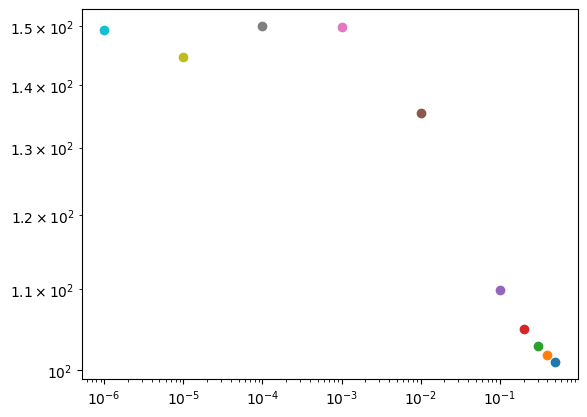

In [205]:
sid = 0
temp = final.trajectory.temperature.copy()
ke = final.trajectory.ke_total.copy()
pe = final.trajectory.pe_total.copy()
te = ke + pe

mask = final.original_system_id == sid
for delta_phi in np.unique(final.delta_phi):
    mask2 = (final.delta_phi == delta_phi) & (mask)
    # plt.scatter(np.mean(ke[:, mask2], axis=0), np.mean(te[:, mask2], axis=0) / np.mean(ke[:, mask2], axis=0))
    # plt.scatter(np.mean(temp[:, mask2], axis=0), np.mean(te[:, mask2], axis=0))
    x = np.mean(temp[:, mask2], axis=0)
    y = np.mean(te[:, mask2], axis=0)
    y = y[np.argsort(x)]
    x = x[np.argsort(x)]
    
    # plt.plot(x, y)
    
    x_fit = np.linspace(min(x), max(x), 100)
    # m, b = np.polyfit(x, y, 1)
    # plt.plot(x_fit, m * x_fit + b)

    spline = make_smoothing_spline(x, y, lam=1e-9)
    y_fit = spline(x_fit)
    # plt.plot(x_fit, y_fit)
    
    slope = spline(x_fit, nu=1)
    # plt.plot(x_fit, slope)
    
    plt.scatter(-delta_phi, np.mean(slope))
plt.xscale('log')
plt.yscale('log')

# RB

In [ ]:
N_temp_steps = 100
delta_phis = [-1e-6, -1e-5, -1e-4, -1e-3, -1e-2, -1e-1, -2e-1, -3e-1, -4e-1, -5e-1]

for p in os.listdir(os.path.join(root, 'jamming')):
    if 'disk' in p:
        continue
    all_temps, all_delta_phis = [], []
    all_data = []
    data = dp.data.load(os.path.join(root, 'jamming', p, 'jamming'), location=['final', 'init'])
    for fname in ['friction_coeff', 'hessian_tt', 'hessian_tx', 'hessian_ty', 'hessian_xt', 'hessian_xx', 'hessian_xy', 'hessian_yt', 'hessian_yx', 'hessian_yy', 'pair_forces', 'pair_ids', 'pair_vertex_contacts']:
        del data.final.arrays[fname]
    for temperature in np.linspace(1e-5, 1e-1, N_temp_steps):
        for delta_phi in delta_phis:
            all_temps.append(temperature)
            all_delta_phis.append(delta_phi)
            all_data.append(data)
    data_new = join_systems(all_data)
    print('scaling')
    data_new.scale_to_packing_fraction(data_new.packing_fraction + np.array(all_delta_phis))
    print('setting temp')
    data_new.set_velocities(np.array(all_temps), np.random.randint(0, 1e9))
    data_new.add_array(np.array(all_delta_phis), 'delta_phi')
    data_new.add_array(np.array(all_temps), 'target_temp')

    rb_dynamics_path = os.path.join(root, 'rb-dynamics', p)
    data_new.set_neighbor_method(NeighborMethod.Cell)
    set_standard_cell_list_parameters(data_new, 0.3)
    data_new.save(rb_dynamics_path)

    n_steps = 1e5
    save_freq = 1e2
    dt = 1e-2

    subprocess.run([
        os.path.join("/home/mmccraw/dev/dpmd/build/", "nve_rigid_bumpy_pbc_final"),
        rb_dynamics_path,
        rb_dynamics_path,
        str(n_steps),
        str(save_freq),
        str(dt),
    ], check=True)

scaling
setting temp


In [265]:
dynamics_base = os.path.join(root, 'rb-dynamics')

ke = []
pe = []
te = []
temp = []
delta_phi = []
temp_target = []
mu_eff = []
nv = []
all_data = []
for fname in tqdm(os.listdir(dynamics_base)):
    path = os.path.join(dynamics_base, fname)
    if os.path.isfile(path):
        continue
    d = dp.data.load(path, location=['final', 'init'], load_trajectory=True)
    pe.append(d.trajectory.pe_total)
    ke.append(d.trajectory.ke_total)
    te.append(d.trajectory.ke_total + d.trajectory.pe_total)
    temp.append(d.trajectory.temperature)
    temp_target.append(d.target_temp)
    delta_phi.append(d.delta_phi)
    d.calculate_mu_eff()
    mu_eff.append(d.mu_eff[d.system_offset[:-1]])
    nv.append(d.n_vertices_per_particle[d.system_offset[:-1]] - 1)

nv = np.concatenate(nv)
mu_eff = np.concatenate(mu_eff)
delta_phi = np.concatenate(delta_phi)
temp_target = np.concatenate(temp_target)
temp = np.concatenate(temp, axis=1)
te = np.concatenate(te, axis=1)
ke = np.concatenate(ke, axis=1)
pe = np.concatenate(pe, axis=1)

100%|██████████| 27/27 [00:00<00:00, 88.33it/s]


In [266]:
cv_data = {
    'nv': [],
    'mu_eff': [],
    'cv': [],
    'dphi': []
}

for _nv in np.unique(nv):
    nv_mask = nv == _nv
    for _mu in np.unique(mu_eff[nv_mask]):
        mu_eff_mask = mu_eff == _mu
        for dphi in np.unique(delta_phi[mu_eff_mask & nv_mask]):
            x = np.mean(temp[:, (delta_phi == dphi) & mu_eff_mask & nv_mask], axis=0)
            y = np.mean(te[:, (delta_phi == dphi) & mu_eff_mask & nv_mask], axis=0)
            y = y[np.argsort(x)]
            x = x[np.argsort(x)]
            
            # plt.plot(x, y)
            x_fit = np.linspace(min(x), max(x), 100)
            spline = make_smoothing_spline(x, y, lam=1e-9)
            y_fit = spline(x_fit)
            # plt.plot(x_fit, y_fit)
            slope = spline(x_fit, nu=1)
            # plt.plot(x_fit, slope)
            # plt.scatter(-dphi, np.mean(slope))

            cv_data['nv'].append(_nv)
            cv_data['mu_eff'].append(_mu)
            cv_data['cv'].append(np.mean(slope))
            cv_data['dphi'].append(-dphi)
cv_data = pd.DataFrame(cv_data)

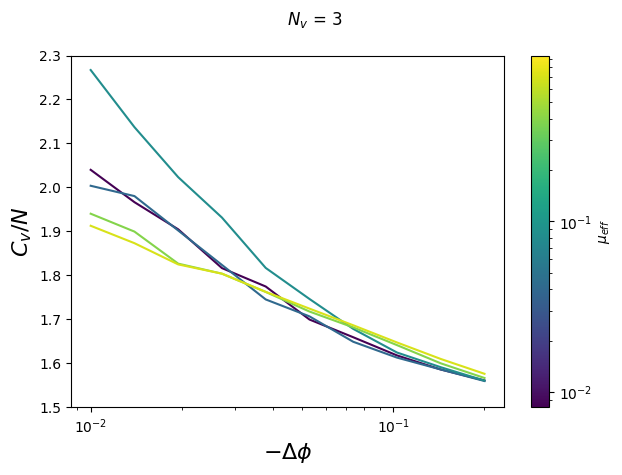

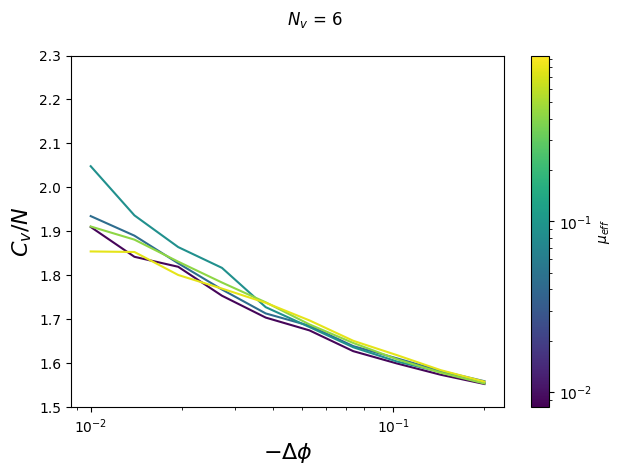

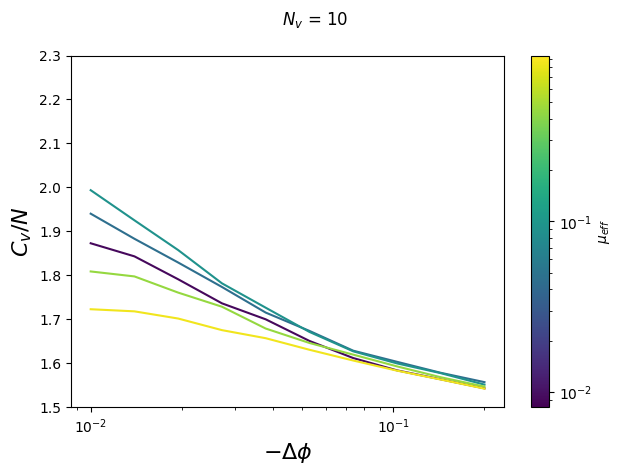

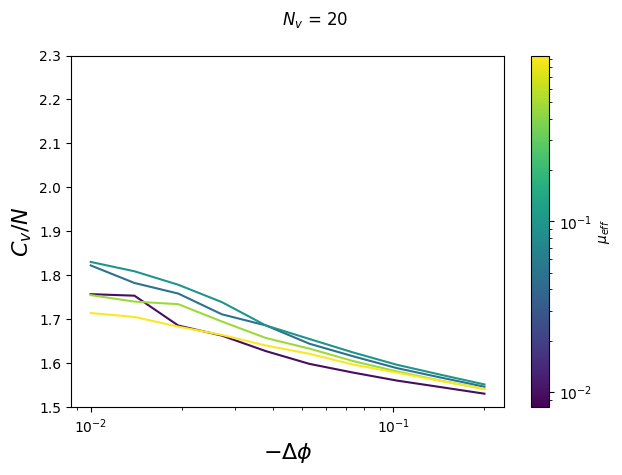

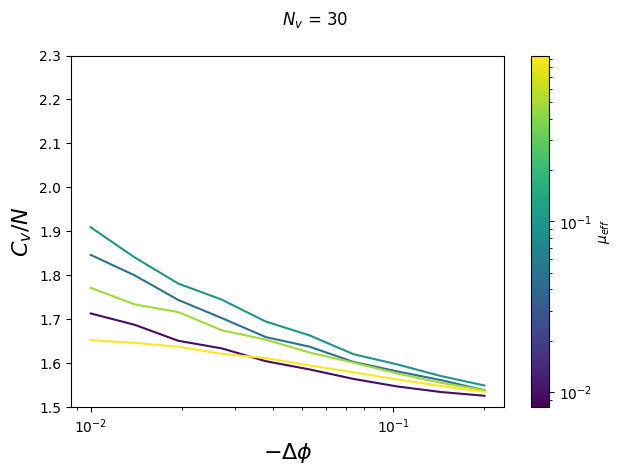

In [282]:
mu_norm = LogNorm(vmin=cv_data.mu_eff.min(), vmax=cv_data.mu_eff.max())
cmap = plt.cm.viridis

for _nv in np.unique(cv_data.nv):
    for _mu in np.unique(cv_data[cv_data.nv == _nv].mu_eff):
        df = cv_data[(cv_data.nv == _nv) & (cv_data.mu_eff == _mu)]
        plt.plot(df.dphi, df.cv / 100, c=cmap(mu_norm(_mu)))
    plt.xscale('log')
    # plt.yscale('log')
    plt.ylim(1.5, 2.3)
    plt.ylabel(r'$C_v / N$', fontsize=16)
    plt.xlabel(r'$-\Delta \phi$', fontsize=16)
    sm = plt.cm.ScalarMappable(norm=mu_norm, cmap=cmap)
    sm.set_array(cv_data.mu_eff.values)
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
    plt.suptitle(fr'$N_v$ = {int(_nv)}')
    plt.tight_layout()
    plt.savefig(f'figures/heat-capacity/cv-{_nv}.png', dpi=600)
    plt.show()

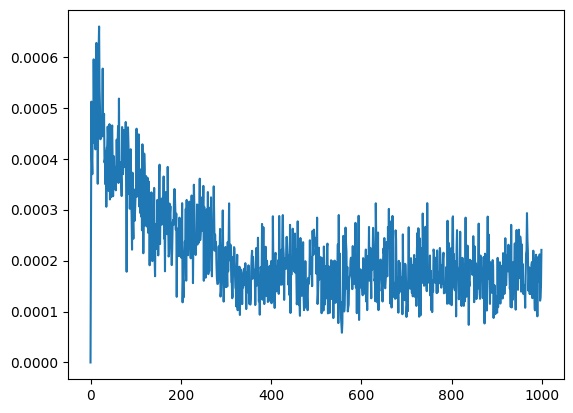

In [ ]:
plt.plot(pe[:, 10])